1.Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform?

In [ ]:
import pandas as pd
import numpy as np
import os

def preprocess_simple(input_file, output_file):
    try:
        with open(input_file, 'r') as f:
            lines = f.readlines()

        data_lines = []
        for line in lines:
            if line.strip() and not line.strip().startswith('#'):
                if any(char.isdigit() or char == '-' or char == '.' for char in line):
                    data_lines.append(line.strip())

        data = []
        for line in data_lines:
            clean_line = line.replace('|', '').strip()
            if clean_line:
                values = clean_line.split(',')
                if len(values) >= 5:
                    try:
                        row = [float(val.strip()) for val in values[:5]]
                        data.append(row)
                    except ValueError:
                        continue

        df = pd.DataFrame(data, columns=['time', 'accx', 'accy', 'accz', 'aT'])

        total_samples = len(df)

        if total_samples < 1000:
            print(f"Warning: Only {total_samples} samples in {input_file}, need at least 1000")
            return

        middle_start = (total_samples - 1000) // 2
        middle_data = df.iloc[middle_start:middle_start + 1000]

        # Downsample to 50Hz by taking every other sample
        downsampled_data = middle_data.iloc[::2]

        result = downsampled_data[['accx', 'accy', 'accz']].copy()

        result.to_csv(output_file, index=False)
        print(f"Processed {input_file} -> {output_file} ({len(result)} samples)")

    except Exception as e:
        print(f"Error processing {input_file}: {e}")

folder_path = "/content/drive/MyDrive/task_03_data"

for filename in os.listdir(folder_path):
    if filename.endswith('.csv') and not filename.startswith('preprocessed_'):
        input_file = os.path.join(folder_path, filename)
        output_file = os.path.join(folder_path, f"preprocessed_{filename}")
        preprocess_simple(input_file, output_file)

Processed /content/drive/MyDrive/task_03_data/upstairs _03.csv -> /content/drive/MyDrive/task_03_data/preprocessed_upstairs _03.csv (500 samples)
Processed /content/drive/MyDrive/task_03_data/standing_03.csv -> /content/drive/MyDrive/task_03_data/preprocessed_standing_03.csv (500 samples)
Processed /content/drive/MyDrive/task_03_data/walking3.csv -> /content/drive/MyDrive/task_03_data/preprocessed_walking3.csv (500 samples)
Processed /content/drive/MyDrive/task_03_data/upstairs_02.csv -> /content/drive/MyDrive/task_03_data/preprocessed_upstairs_02.csv (500 samples)
Processed /content/drive/MyDrive/task_03_data/walking1.csv -> /content/drive/MyDrive/task_03_data/preprocessed_walking1.csv (500 samples)
Processed /content/drive/MyDrive/task_03_data/upstairs _01.csv -> /content/drive/MyDrive/task_03_data/preprocessed_upstairs _01.csv (500 samples)
Processed /content/drive/MyDrive/task_03_data/Standing_01.csv -> /content/drive/MyDrive/task_03_data/preprocessed_Standing_01.csv (500 samples)


Training the model on UCI-HAR dataset...
UCI-HAR Model Accuracy: 0.7105
Precision: 0.6941
Recall: 0.7105
Confusion Matrix:
[[8 0 0 0 0 0]
 [0 7 0 0 0 0]
 [0 0 5 1 0 0]
 [0 1 0 2 2 1]
 [0 0 1 0 3 1]
 [0 0 2 1 1 2]]

Predicting activities for your preprocessed data...
preprocessed_upstairs _03.csv: Predicted as WALKING_UPSTAIRS
preprocessed_standing_03.csv: Predicted as LAYING
preprocessed_walking3.csv: Predicted as LAYING
preprocessed_upstairs_02.csv: Predicted as SITTING
preprocessed_walking1.csv: Predicted as LAYING
preprocessed_upstairs _01.csv: Predicted as LAYING
preprocessed_Standing_01.csv: Predicted as LAYING
preprocessed_Walking2.csv: Predicted as SITTING
preprocessed_sitting_03.csv: Predicted as LAYING
preprocessed_laying _01.csv: Predicted as LAYING
preprocessed_laying_02.csv: Predicted as LAYING
preprocessed_downstairs_02.csv: Predicted as WALKING_DOWNSTAIRS
preprocessed_laying_03.csv: Predicted as LAYING
preprocessed_sitting_01.csv: Predicted as LAYING
preprocessed_standing

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


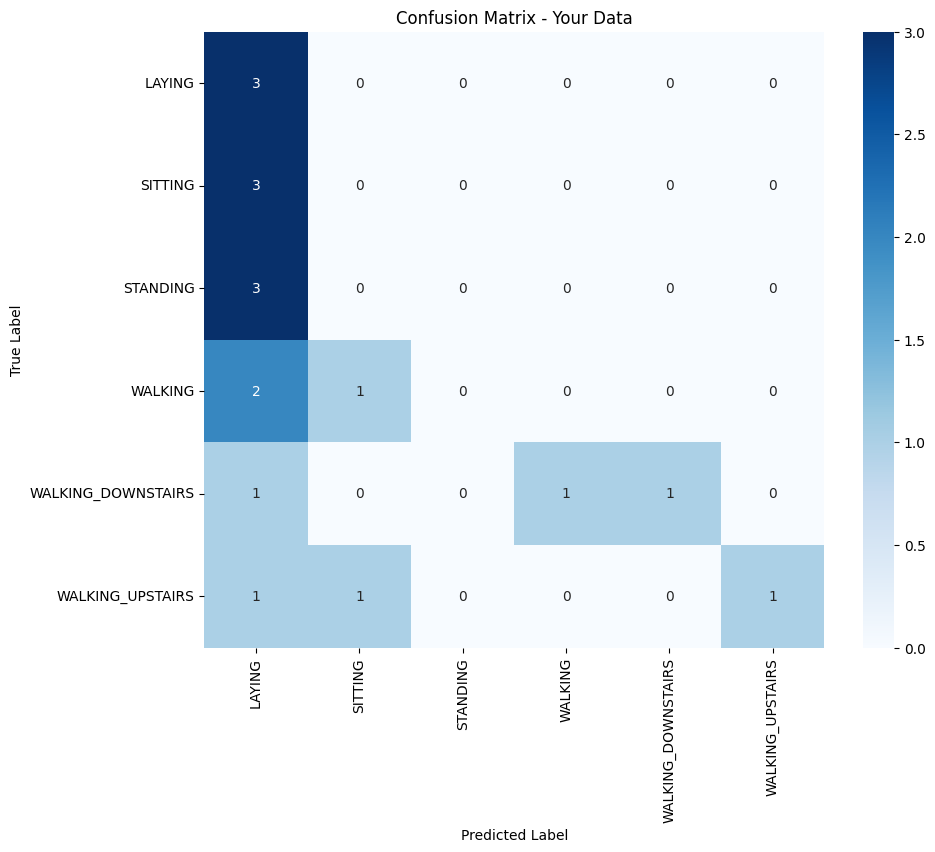

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

print("Training the model on UCI-HAR dataset")

activity_paths = {
    'LAYING': r"/content/drive/MyDrive/Combined/Train/LAYING",
    'SITTING': r"/content/drive/MyDrive/Combined/Train/SITTING",
    'STANDING': r"/content/drive/MyDrive/Combined/Train/STANDING",
    'WALKING': r"/content/drive/MyDrive/Combined/Train/WALKING",
    'WALKING_DOWNSTAIRS': r"/content/drive/MyDrive/Combined/Train/WALKING_DOWNSTAIRS",
    'WALKING_UPSTAIRS': r"/content/drive/MyDrive/Combined/Train/WALKING_UPSTAIRS"
}

feature_list = []
activity_labels = []

for label, directory in activity_paths.items():
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)

        # Extract first 500 samples of each axis
        x_vals = df['accx'].iloc[:500].to_numpy()
        y_vals = df['accy'].iloc[:500].to_numpy()
        z_vals = df['accz'].iloc[:500].to_numpy()

        # Combine axis data into a single feature vector
        combined_features = np.hstack((x_vals, y_vals, z_vals))

        feature_list.append(combined_features)
        activity_labels.append(label)

features = np.array(feature_list)
labels = np.array(activity_labels)

# Encode labels to numeric values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, numeric_labels, test_size=0.3, random_state=42)
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

acc1 = accuracy_score(y_test, y_pred)
prec1, rec1, _, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_mat1 = confusion_matrix(y_test, y_pred)

print(f"UCI-HAR Model Accuracy: {acc1:.4f}")
print(f"Precision: {prec1:.4f}")
print(f"Recall: {rec1:.4f}")
print("Confusion Matrix:")
print(conf_mat1)

print("\n" + "="*50)
print("Predicting activities for your preprocessed data")

preprocessed_folder = "/content/drive/MyDrive/task_03_data"

# we have choose to predict use the model trained on raw data
def predict_activities_from_preprocessed_data(preprocessed_folder_path):
    predictions = []

    for filename in os.listdir(preprocessed_folder_path):
        if filename.startswith('preprocessed_') and filename.endswith('.csv'):
            filepath = os.path.join(preprocessed_folder_path, filename)

            try:
                df = pd.read_csv(filepath)

                # Extract all samples of each axis
                x_vals = df['accx'].to_numpy()
                y_vals = df['accy'].to_numpy()
                z_vals = df['accz'].to_numpy()

                # Combine axis data into a single feature vector (same format as training)
                combined_features = np.hstack((x_vals, y_vals, z_vals))

                # Reshape for prediction (1 sample with 1500 features)
                features_for_prediction = combined_features.reshape(1, -1)

                # Predict
                prediction = classifier.predict(features_for_prediction)
                activity = label_encoder.inverse_transform(prediction)[0]

                predictions.append({
                    'filename': filename,
                    'predicted_activity': activity
                })

                print(f"{filename}: Predicted as {activity}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    return predictions
your_predictions = predict_activities_from_preprocessed_data(preprocessed_folder)

print("\nPrediction Results:")
for prediction in your_predictions:
    print(f"{prediction['filename']}: {prediction['predicted_activity']}")

# Calculate accuracy if you know the true label
true_activity_map = {
    'preprocessed_walking1.csv': 'WALKING',
    'preprocessed_walking2.csv': 'WALKING',
    'preprocessed_walking3.csv': 'WALKING',
    'preprocessed_standing_01.csv': 'STANDING',
    'preprocessed_standing_02.csv': 'STANDING',
    'preprocessed_standing_03.csv': 'STANDING',
    'preprocessed_sitting_01.csv': 'SITTING',
    'preprocessed_sitting_02.csv': 'SITTING',
    'preprocessed_sitting_03.csv': 'SITTING',
    'preprocessed_laying_01.csv': 'LAYING',
    'preprocessed_laying_02.csv': 'LAYING',
    'preprocessed_laying_03.csv': 'LAYING',
    'preprocessed_upstairs_01.csv': 'WALKING_UPSTAIRS',
    'preprocessed_upstairs_02.csv': 'WALKING_UPSTAIRS',
    'preprocessed_upstairs_03.csv': 'WALKING_UPSTAIRS',
    'preprocessed_downstairs_01.csv': 'WALKING_DOWNSTAIRS',
    'preprocessed_downstairs_02.csv': 'WALKING_DOWNSTAIRS',
    'preprocessed_downstairs_03.csv': 'WALKING_DOWNSTAIRS',

    'preprocessed_upstairs _03.csv': 'WALKING_UPSTAIRS',
    'preprocessed_upstairs _01.csv': 'WALKING_UPSTAIRS',
    'preprocessed_Standing_01.csv': 'STANDING',
    'preprocessed_Walking2.csv': 'WALKING',
    'preprocessed_laying _01.csv': 'LAYING',
    'preprocessed_standing _02.csv': 'STANDING',
    'preprocessed_downstairs _03.csv': 'WALKING_DOWNSTAIRS'
}

if true_activity_map:
    correct = 0
    total = 0
    true_labels = []
    pred_labels = []

    print("\nAccuracy Calculation:")

    # Create a normalized version of the true_activity_map
    normalized_map = {}
    for key, value in true_activity_map.items():
        # Normalize the key by making it lowercase and removing all spaces and underscores
        normalized_key = key.lower().replace(' ', '').replace('_', '')
        normalized_map[normalized_key] = value

    for prediction in your_predictions:
        filename = prediction['filename']
        predicted = prediction['predicted_activity']

        # Normalize the filename for matching
        normalized_filename = filename.lower().replace(' ', '').replace('_', '')

        if normalized_filename in normalized_map:
            true_activity = normalized_map[normalized_filename]
            status = "✓" if predicted == true_activity else "✗"
            print(f"{filename}: True={true_activity}, Predicted={predicted} {status}")

            if predicted == true_activity:
                correct += 1
            total += 1

            true_labels.append(true_activity)
            pred_labels.append(predicted)
        else:
            print(f"{filename}: No true label found in mapping")

    if total > 0:
        accuracy = correct / total

        # Converted to numeric for precision/recall calculation
        true_numeric = label_encoder.transform(true_labels)
        pred_numeric = label_encoder.transform(pred_labels)

        precision, recall, _, _ = precision_recall_fscore_support(true_numeric, pred_numeric, average='weighted')
        conf_matrix = confusion_matrix(true_numeric, pred_numeric)

        print(f"\nAccuracy on your data: {accuracy:.4f} ({correct}/{total} correct)")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)

        # confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix - Your Data')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("\nNo matching files found for accuracy calculation")
else:
    print("\nNote: For accuracy calculation, fill in the true_activity_map dictionary with your actual labels")

The results from the confusion matrix clearly show that our model underperformed on the collected data, achieving an accuracy of only 5/18 samples.